In [2]:
import json

In [3]:
import os
print(os.getcwd())

/home/vibha/Documents/Research/project3/New/1


In [4]:
import warnings
warnings.filterwarnings('ignore')

In [5]:
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

In [6]:
import matplotlib.pyplot as plt
from PIL import Image
import pickle
import pandas as pd

In [7]:
from numpy.linalg import norm
from decimal import Decimal, ROUND_HALF_EVEN

In [8]:
from fb_utils import *

In [9]:
from UTKFace_train_utils import *

In [10]:
def get_gen_acc(dl, model, concept_index, foolbox_model=False):
    acc_after = 0

    for batch_index, batch in enumerate(dl):
        concept_label = batch['labels'][concept_index]
        if not foolbox_model:
            imgs = batch['image_norm']
            yp_after = model(imgs.cuda()).cpu()
        else:
            imgs = batch['image']
            yp_after = model(ep.astensor(imgs.cuda())).raw.cpu()

        acc_after += (yp_after.max(dim=1)[1] == concept_label).sum().item()

    return acc_after

In [11]:
def get_gen_loss(dl, model, concept_index, foolbox_model=False, avg_overall_loss=True):
    #acc_after = 0
    avg_loss_list = []

    for batch_index, batch in enumerate(dl):
        concept_label = batch['labels'][concept_index]
        if not foolbox_model:
            imgs = batch['image_norm']
            loss_tensor = model(imgs.cuda()).cpu()
        else:
            imgs = batch['image']
            loss_tensor = model(ep.astensor(imgs.cuda())).raw.cpu()

        if avg_overall_loss:
            avg_loss = torch.mean(loss_tensor)
            avg_loss_list.append(avg_loss.item())
        else:
             for i in range(len(concept_label)):
                curr_label = concept_label[i]
                curr_loss = loss_tensor[i][curr_label]
                avg_loss_list.append(curr_loss.item())
        
    avg_loss = sum(avg_loss_list)/len(avg_loss_list)
    print(avg_loss)
    return avg_loss

In [12]:
def get_advx_acc_across_iters(advx_batches, df_advx_dict, model, concept, img_key, num_iters=11, len_df=1000):
    acc_after_dict = {i: None for i in range(num_iters)}

    for i in range(num_iters):
        acc_after = np.round(get_advx_acc(advx_batch_list=advx_batches, advx_dict=df_advx_dict,
                                          model=model, concept=concept, img_key=img_key, iterations=i) / len_df * 100,
                             2)
        acc_after_dict[i] = acc_after

    return acc_after_dict

In [13]:
#given advx_batches
def get_gen_acc(advx_batch_list, advx_dict, model, concept='age', img_key='advx'):
    acc_after = 0

    for batch_index in advx_batch_list:
        img_names = advx_batch_list[batch_index]['img_names']
        labels = []

        for _, img in enumerate(img_names):
            labels.append(advx_dict[img][concept])
        labels = torch.tensor(labels).cpu()
        advs_ = advx_batch_list[batch_index][img_key]
        if type(advs_) == list or len(advs_) == 1:
            advs_ = advs_[0]

        yp_after = model(advs_.cuda()).cpu()
        acc_after += (yp_after.max(dim=1)[1] == labels).sum().item()

    return acc_after

In [14]:
def get_minmax_loss_diff_label(dataloader, model, label_idx, is_max=True):
    label_dict = {}
    label_dict_groundtruth = {}
    
    for batch_idx, batch in enumerate(dataloader):
        
        minmax_label = []
        groundtruth_label = []
        
        concept_label = batch['labels'][label_idx]
        imgs = batch['image_norm']
        loss_val = model(imgs.cuda()).cpu()
        
        for i in range(len(concept_label)):
            curr_label = concept_label[i]
            
            label1 = abs(curr_label-2)
            loss1 = abs(loss_val[i][curr_label] - loss_val[i][label1])
            
            label2 = abs(curr_label-1)
            loss2 = abs(loss_val[i][curr_label] - loss_val[i][label2])
            
            #print(f"label1:{label1}, label2:{label2}, curr_label:{curr_label}")
            #print(f"loss1:{loss1}")
            #print(f"loss2:{loss2}")
            
            if is_max:
                if loss1 > loss2:
                    minmax_label.append(label1.item())
                else:
                    minmax_label.append(label2.item())
            else:
                if loss1 > loss2:
                    minmax_label.append(label2.item())
                else:
                    minmax_label.append(label1.item())
            groundtruth_label.append(curr_label.item())
            
            #print(f"groundtruth: {groundtruth_label}")
            #print(f"max_label:{minmax_label}")
            #sys.exit()

        #print(minmax_label)
        label_dict[batch_idx] = minmax_label
        label_dict_groundtruth[batch_idx] = groundtruth_label

    return label_dict, label_dict_groundtruth

In [15]:
def custom_advx_wrapper(parent_dir, advx_dict, df_advx, dl_dict, norm='linf', concept_list=None):
    if concept_list is None:
        concept_list = [('gender', model_gender), ('age', model_age), ('glasses', model_glasses), ('pretty', model_pretty)]
    
    file_list = sorted(os.listdir(parent_dir))
    for curr_file in file_list:
        print(f"File_name: {curr_file}")
        attack_concepts = curr_file.split("_"+norm+"_")[-1].split("_")[0]
        defend_concepts = curr_file.split("_"+norm+"_")[-1].split("_")[1]
        print(f"Custom {norm} norm advx with Attack concepts: {attack_concepts} and Defend concepts: {defend_concepts}")
        
        advx_batches = pickle.load(open(os.path.join(parent_dir, curr_file), 'rb'))
        dict_X_to_label_mapping = get_x_to_label_mapping(advx_batches, dl_dict)
        if norm=='linf':
            assert_lp_bound(advx_batches, dict_X_to_label_mapping, eps=0.3, norms='linf')
        elif norm=='l2':
            assert_lp_bound(advx_batches, dict_X_to_label_mapping, eps=4.0, norms='l2')
        else:
            raise NotImplementedError
        
        for concept_tuple in concept_list:
            concept = concept_tuple[0]
            model = concept_tuple[1]
            acc_ = np.round(get_advx_acc(advx_batch_list=advx_batches, advx_dict=advx_dict, model=model, concept=concept, img_key='advx', iterations=None)/len(df_advx)*100, 2)
            print(f"Acc of {concept} concept: {acc_}")
            del acc_ 
        del advx_batches
    
        print()

## Main

In [16]:
#df_advx = pd.read_csv('df_gender_age_UTKFace.csv') # not relevant
#df_advx = pd.read_csv('df_utkface_4000.csv') # not relevant
#df_advx_1000_dict = get_pdadvx_dict_utkface(df_advx) # not relevent
df_advx = pd.read_csv('df_utkface_1000.csv')
df_advx_1000_dict = get_pdadvx_dict_utkface(df_advx)

In [17]:
df_advx_multi = pd.read_csv('df_utkface_1000_multi.csv')
df_advx_1000_dict_multi = get_pdadvx_dict_utkface(df_advx_multi)

In [18]:
#generate df_advx multi:

#df_age_multi = pickle.load(open("df_age_multi.p", "rb"))
#df_age_multi.rename(columns = {'image_id':'name'}, inplace = True)
#df_advx_multi = pd.merge(df_age_multi, df_advx, how='inner', on=['name'])

#df_advx_multi.rename(columns = {'age_x':'age'}, inplace = True)
#df_advx_multi.drop(['is_valid', 'age_y'], axis=1, inplace=True)

#df_advx_multi.to_csv('df_utkface_1000_multi.csv', index=False)

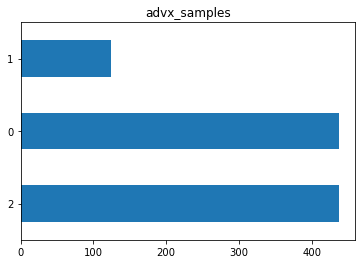

In [19]:
(df_advx_multi.age.value_counts()).plot.barh()
plt.title("advx_samples");

In [20]:
torch.cuda.set_device(0)
device, kwargs = set_device(device_name="cuda:0")
print(device, kwargs)
torch.cuda.empty_cache()

cuda:0 {'num_workers': 1, 'pin_memory': True}


In [21]:
model_age_multi, fmodel_age_multi = get_foolbox_model(weights_file='stage-2-rn50-age-multi-utk-final.pth', dev=device, 
                                          num_classes=3, is_torch=False, preprocess=True, models_dir='models')

In [22]:
dataloader_multi = get_dataloader(kwargs_func=kwargs, batch_size=20, pd_advx=df_advx_multi, root_dir='', img_pkl_file=None, is_for_train=False)

In [23]:
dataloader_dict_multi_1000 = get_dataloader_dict(data_loader=dataloader_multi)

In [24]:
model_age, fmodel_age = get_foolbox_model(weights_file='stage-2-rn50-age-utk.pth', dev=device, 
                                          num_classes=2, is_torch=False, preprocess=True, models_dir='models')

In [25]:
model_gender, fmodel_gender = get_foolbox_model(weights_file='stage-2-rn50-gender-utk.pth', dev=device, 
                                                num_classes=2, is_torch=False, preprocess=True, models_dir='models')

In [26]:
model_ethnicity, fmodel_ethnicity = get_foolbox_model(weights_file='stage-2-rn50-ethnicity-utk.pth', dev=device, 
                                          num_classes=2, is_torch=False, preprocess=True, models_dir='models')

In [27]:
dataloader = get_dataloader(kwargs_func=kwargs, batch_size=20, pd_advx=df_advx, root_dir='', img_pkl_file=None, is_for_train=False)

In [28]:
dataloader_dict_1000 = get_dataloader_dict(data_loader=dataloader)

In [29]:
# get the conceptDict lst and model_list
concept_dict = {'age': 0, 'gender': 1, 'ethnicity': 2}

## Accuracy of original models on sample dataset

### Avg loss wrt original image

In [19]:
avg_loss_age_multi = get_gen_loss(dataloader_multi, model_age_multi, concept_index=concept_dict['age'], foolbox_model=False, avg_overall_loss=True)

-0.21577764615416528


In [28]:
overall_avg_loss_gender = get_gen_loss(dataloader, model_gender, concept_index=concept_dict['gender'], foolbox_model=False, avg_overall_loss=True)

0.03962870952207595


In [29]:
overall_avg_loss_age = get_gen_loss(dataloader, model_age, concept_index=concept_dict['age'], foolbox_model=False, avg_overall_loss=True)

-0.10775817841291428


In [30]:
overall_avg_loss_ethnicity = get_gen_loss(dataloader, model_ethnicity, concept_index=concept_dict['ethnicity'], foolbox_model=False, avg_overall_loss=True)

0.026964987302199005


### Avg loss wrt original image (ground truth labels)

In [20]:
gt_avg_loss_age_multi = get_gen_loss(dataloader_multi, model_age_multi, concept_index=concept_dict['age'], foolbox_model=False, avg_overall_loss=False)

4.471319838389754


In [36]:
gt_avg_loss_gender = get_gen_loss(dataloader, model_gender, concept_index=concept_dict['gender'], foolbox_model=False, avg_overall_loss=False)

6.654510481961071


In [37]:
gt_avg_loss_age = get_gen_loss(dataloader, model_age, concept_index=concept_dict['age'], foolbox_model=False, avg_overall_loss=False)

3.4775758042149247


In [38]:
gt_avg_loss_ethnicity = get_gen_loss(dataloader, model_ethnicity, concept_index=concept_dict['ethnicity'], foolbox_model=False, avg_overall_loss=True)

0.026964987302199005


In [ ]:
maxlabel_dict_multi, groundtruth_dict_multi = get_minmax_loss_diff_label(dataloader=dataloader_multi, model=model_age_multi, label_idx=concept_dict['age'], is_max=True)

In [35]:
pickle.dump(groundtruth_dict_multi, open("groundtruthlabel_multi_age.p", "wb"))

In [11]:
for a, b in zip(temp1,temp2):
    print(temp1[a], temp2[b])
    break

[0, 1, 1, 0, 1, 0, 2, 2, 2, 0, 1, 0, 0, 2, 0, 0, 0, 0, 2, 1] [2, 0, 0, 2, 0, 2, 0, 0, 0, 2, 0, 1, 2, 0, 2, 1, 2, 2, 0, 0]


In [9]:
temp2 = pickle.load(open("maxlabel_multi_age.p", "rb"))

In [10]:
temp1 = pickle.load(open("groundtruthlabel_multi_age.p", "rb"))

In [26]:
for k in temp2:
    assert(temp2[k]==maxlabel_dict_multi[k])

In [27]:
dataloader_multi2 = get_dataloader(kwargs_func=kwargs, batch_size=20, pd_advx=df_advx_multi, root_dir='', img_pkl_file=None, is_for_train=False)

In [34]:
for a, b in zip(dataloader_multi, dataloader_multi2):
    assert(a['img_name']==b['img_name'])

In [61]:
minlabel_dict_multi = get_minmax_loss_diff_label(dataloader=dataloader_multi, model=model_age_multi, label_idx=concept_dict['age'], is_max=False)

In [62]:
pickle.dump(maxlabel_dict_multi, open("maxlabel_multi_age.p", "wb"))
pickle.dump(minlabel_dict_multi, open("minlabel_multi_age.p", "wb"))

In [27]:
acc_before_multi = get_gen_acc(dataloader_multi, model_age_multi, concept_index=concept_dict['age'])/len(df_advx_multi)*100

In [29]:
print(f"Accuracy of age (multi) before attack: {np.round(acc_before_multi, 2)}%")

Accuracy of age (multi) before attack: 93.4%


In [27]:
acc_before = get_gen_acc(dataloader, model_age, concept_index=concept_dict['age'])/len(df_advx)*100

In [19]:
print(f"Accuracy of age before attack: {np.round(acc_before, 2)}%")

Accuracy of age before attack: 97.2%


In [20]:
acc_before = get_gen_acc(dataloader, model_gender, concept_index=concept_dict['gender'])/len(df_advx)*100

In [21]:
print(f"Accuracy of gender before attack: {np.round(acc_before, 2)}%")

Accuracy of gender before attack: 99.0%


In [22]:
acc_before = get_gen_acc(dataloader, model_ethnicity, concept_index=concept_dict['ethnicity'])/len(df_advx)*100

In [23]:
print(f"Accuracy of ethnicity before attack: {np.round(acc_before, 2)}%")

Accuracy of ethnicity before attack: 100.0%


In [30]:
os.listdir('final_exp_utkface')

['fb_deepfool',
 'avg_losses',
 '2_attack_1_defend',
 '1_attack_2_defend',
 'weights_hyperparam',
 'foolbox',
 'fb_fgsm',
 'multi',
 '1_attack_1_defend',
 'maybe',
 'torchattacks_cw']

## Foolbox attacks UTKFace

# Hyperparameter tuning

In [36]:
concept_dict = {'age': 0, 'gender': 1, 'ethnicity': 2}
concept_list = [('gender', model_gender), ('age', model_age), ('ethnicity', model_ethnicity)]

advx_batches = pickle.load(open('final_exp_utkface/foolbox/linf/pgd_fb_linf_age_eps_0.3_utkface_stepsize_40_10001.pkl', 'rb'))
dict_X_to_label_mapping = get_x_to_label_mapping(advx_batches, dataloader_dict_1000)
    
for concept_tuple in concept_list:
    concept = concept_tuple[0]
    model = concept_tuple[1]
    acc_ = get_advx_acc_across_iters(advx_batches=advx_batches, df_advx_dict=df_advx_1000_dict, model=model, concept=concept, 
                                     img_key='advx', num_iters=3, len_df=len(df_advx))
    print(f"Acc of {concept} concept: {acc_}")
    del acc_ 
del advx_batches
    
print()

Acc of gender concept: {0: 50.6, 1: 50.1, 2: 50.2}
Acc of age concept: {0: 50.0, 1: 32.8, 2: 30.0}
Acc of ethnicity concept: {0: 60.3, 1: 58.8, 2: 58.7}



In [37]:
concept_dict = {'age': 0, 'gender': 1, 'ethnicity': 2}
concept_list = [('gender', model_gender), ('age', model_age), ('ethnicity', model_ethnicity)]

advx_batches = pickle.load(open('final_exp_utkface/foolbox/linf/pgd_fb_linf_gender_eps_0.3_utkface_stepsize_40_10001.pkl', 'rb'))
dict_X_to_label_mapping = get_x_to_label_mapping(advx_batches, dataloader_dict_1000)
    
for concept_tuple in concept_list:
    concept = concept_tuple[0]
    model = concept_tuple[1]
    acc_ = get_advx_acc_across_iters(advx_batches=advx_batches, df_advx_dict=df_advx_1000_dict, model=model, concept=concept, 
                                     img_key='advx', num_iters=3, len_df=len(df_advx))
    print(f"Acc of {concept} concept: {acc_}")
    del acc_ 
del advx_batches
    
print()

Acc of gender concept: {0: 43.0, 1: 5.6, 2: 7.0}
Acc of age concept: {0: 50.0, 1: 50.0, 2: 50.0}
Acc of ethnicity concept: {0: 60.8, 1: 58.4, 2: 58.5}



In [52]:
acc_gender = get_advx_acc_across_iters(advx_batches=advx_batches, df_advx_dict=df_advx_1000_dict, model=model_gender, concept='gender', 
                                       img_key='advx', num_iters=2, len_df=len(df_advx))
acc_age = get_advx_acc_across_iters(advx_batches=advx_batches, df_advx_dict=df_advx_1000_dict, model=model_age, concept='age', 
                                    img_key='advx', num_iters=2, len_df=len(df_advx))
acc_ethnicity = get_advx_acc_across_iters(advx_batches=advx_batches, df_advx_dict=df_advx_1000_dict, model=model_ethnicity, concept='ethnicity', 
                                        img_key='advx', num_iters=2, len_df=len(df_advx))

print("FOOLBOX LINF ADVX EXAMPLES OF ATTACK AGE:")
print(f"Acc of age concept: {acc_age}")
print(f"Acc of gender concept: {acc_gender}")
print(f"Acc of ethnicity concept: {acc_ethnicity}")

FOOLBOX LINF ADVX EXAMPLES OF ATTACK AGE:
Acc of age concept: {0: 85.9, 1: 86.4}
Acc of gender concept: {0: 83.7, 1: 66.8}
Acc of ethnicity concept: {0: 86.4, 1: 86.4}


In [53]:
del acc_age, acc_ethnicity, acc_gender, advx_batches
torch.cuda.empty_cache()

In [54]:
advx_batches = pickle.load(open('final_exp_celeba/pgd_fb_linf_gender_eps_0.05_step_40_iter_100.pkl', 'rb'))
dict_X_to_label_mapping = get_x_to_label_mapping(advx_batches, dataloader_dict_1000)

In [55]:
acc_gender = get_advx_acc_across_iters(advx_batches=advx_batches, df_advx_dict=df_advx_1000_dict, model=model_gender, concept='gender', 
                                       img_key='advx', num_iters=2, len_df=len(df_advx))
acc_age = get_advx_acc_across_iters(advx_batches=advx_batches, df_advx_dict=df_advx_1000_dict, model=model_age, concept='age', 
                                    img_key='advx', num_iters=2, len_df=len(df_advx))
acc_ethnicity = get_advx_acc_across_iters(advx_batches=advx_batches, df_advx_dict=df_advx_1000_dict, model=model_ethnicity, concept='ethnicity', 
                                        img_key='advx', num_iters=2, len_df=len(df_advx))

print("FOOLBOX LINF ADVX EXAMPLES OF ATTACK AGE:")
print(f"Acc of age concept: {acc_age}")
print(f"Acc of gender concept: {acc_gender}")
print(f"Acc of ethnicity concept: {acc_ethnicity}")

FOOLBOX LINF ADVX EXAMPLES OF ATTACK AGE:
Acc of age concept: {0: 75.2, 1: 74.7}
Acc of gender concept: {0: 73.8, 1: 15.2}
Acc of ethnicity concept: {0: 76.5, 1: 71.6}


In [56]:
del acc_age, acc_ethnicity, acc_gender, advx_batches
torch.cuda.empty_cache()

In [57]:
advx_batches = pickle.load(open('final_exp_celeba/pgd_fb_linf_gender_eps_0.09_step_40_iter_100.pkl', 'rb'))
dict_X_to_label_mapping = get_x_to_label_mapping(advx_batches, dataloader_dict_1000)

In [58]:
acc_gender = get_advx_acc_across_iters(advx_batches=advx_batches, df_advx_dict=df_advx_1000_dict, model=model_gender, concept='gender', 
                                       img_key='advx', num_iters=2, len_df=len(df_advx))
acc_age = get_advx_acc_across_iters(advx_batches=advx_batches, df_advx_dict=df_advx_1000_dict, model=model_age, concept='age', 
                                    img_key='advx', num_iters=2, len_df=len(df_advx))
acc_ethnicity = get_advx_acc_across_iters(advx_batches=advx_batches, df_advx_dict=df_advx_1000_dict, model=model_ethnicity, concept='ethnicity', 
                                        img_key='advx', num_iters=2, len_df=len(df_advx))

print("FOOLBOX LINF ADVX EXAMPLES OF ATTACK AGE:")
print(f"Acc of age concept: {acc_age}")
print(f"Acc of gender concept: {acc_gender}")
print(f"Acc of ethnicity concept: {acc_ethnicity}")

FOOLBOX LINF ADVX EXAMPLES OF ATTACK AGE:
Acc of age concept: {0: 58.7, 1: 59.4}
Acc of gender concept: {0: 55.7, 1: 2.5}
Acc of ethnicity concept: {0: 68.2, 1: 63.8}


In [59]:
del acc_age, acc_ethnicity, acc_gender, advx_batches
torch.cuda.empty_cache()

In [60]:
advx_batches = pickle.load(open('final_exp_celeba/pgd_fb_linf_gender_eps_0.3_step_40_iter_100.pkl', 'rb'))
dict_X_to_label_mapping = get_x_to_label_mapping(advx_batches, dataloader_dict_1000)

In [61]:
acc_gender = get_advx_acc_across_iters(advx_batches=advx_batches, df_advx_dict=df_advx_1000_dict, model=model_gender, concept='gender', 
                                       img_key='advx', num_iters=2, len_df=len(df_advx))
acc_age = get_advx_acc_across_iters(advx_batches=advx_batches, df_advx_dict=df_advx_1000_dict, model=model_age, concept='age', 
                                    img_key='advx', num_iters=2, len_df=len(df_advx))
acc_ethnicity = get_advx_acc_across_iters(advx_batches=advx_batches, df_advx_dict=df_advx_1000_dict, model=model_ethnicity, concept='ethnicity', 
                                        img_key='advx', num_iters=2, len_df=len(df_advx))

print("FOOLBOX LINF ADVX EXAMPLES OF ATTACK AGE:")
print(f"Acc of age concept: {acc_age}")
print(f"Acc of gender concept: {acc_gender}")
print(f"Acc of ethnicity concept: {acc_ethnicity}")

FOOLBOX LINF ADVX EXAMPLES OF ATTACK AGE:
Acc of age concept: {0: 50.0, 1: 50.0}
Acc of gender concept: {0: 26.9, 1: 5.2}
Acc of ethnicity concept: {0: 58.7, 1: 57.6}


In [62]:
del acc_age, acc_ethnicity, acc_gender, advx_batches
torch.cuda.empty_cache()

In [44]:
advx_batches = pickle.load(open('final_exp_celeba/pgd_fb_linf_gender_eps_0.7_step_40_iter_100.pkl', 'rb'))
dict_X_to_label_mapping = get_x_to_label_mapping(advx_batches, dataloader_dict_1000)

In [45]:
acc_gender = get_advx_acc_across_iters(advx_batches=advx_batches, df_advx_dict=df_advx_1000_dict, model=model_gender, concept='gender', 
                                       img_key='advx', num_iters=2, len_df=len(df_advx))
acc_age = get_advx_acc_across_iters(advx_batches=advx_batches, df_advx_dict=df_advx_1000_dict, model=model_age, concept='age', 
                                    img_key='advx', num_iters=2, len_df=len(df_advx))
acc_ethnicity = get_advx_acc_across_iters(advx_batches=advx_batches, df_advx_dict=df_advx_1000_dict, model=model_ethnicity, concept='ethnicity', 
                                        img_key='advx', num_iters=2, len_df=len(df_advx))

print("FOOLBOX LINF ADVX EXAMPLES OF ATTACK AGE:")
print(f"Acc of age concept: {acc_age}")
print(f"Acc of gender concept: {acc_gender}")
print(f"Acc of ethnicity concept: {acc_ethnicity}")

FOOLBOX LINF ADVX EXAMPLES OF ATTACK AGE:
Acc of age concept: {0: 50.0, 1: 50.0}
Acc of gender concept: {0: 50.0, 1: 50.0}
Acc of ethnicity concept: {0: 43.0, 1: 43.0}


In [46]:
del advx_batches, acc_age, acc_ethnicity, acc_gender
torch.cuda.empty_cache()

In [63]:
advx_batches = pickle.load(open('final_exp_celeba/pgd_fb_l2_gender_eps_0.09_step_40_iter_100.pkl', 'rb'))
dict_X_to_label_mapping = get_x_to_label_mapping(advx_batches, dataloader_dict_1000)

In [64]:
acc_gender = get_advx_acc_across_iters(advx_batches=advx_batches, df_advx_dict=df_advx_1000_dict, model=model_gender, concept='gender', 
                                       img_key='advx', num_iters=2, len_df=len(df_advx))
acc_age = get_advx_acc_across_iters(advx_batches=advx_batches, df_advx_dict=df_advx_1000_dict, model=model_age, concept='age', 
                                    img_key='advx', num_iters=2, len_df=len(df_advx))
acc_ethnicity = get_advx_acc_across_iters(advx_batches=advx_batches, df_advx_dict=df_advx_1000_dict, model=model_ethnicity, concept='ethnicity', 
                                        img_key='advx', num_iters=2, len_df=len(df_advx))

print("FOOLBOX LINF ADVX EXAMPLES OF ATTACK AGE:")
print(f"Acc of age concept: {acc_age}")
print(f"Acc of gender concept: {acc_gender}")
print(f"Acc of ethnicity concept: {acc_ethnicity}")

FOOLBOX LINF ADVX EXAMPLES OF ATTACK AGE:
Acc of age concept: {0: 86.7, 1: 86.6}
Acc of gender concept: {0: 84.7, 1: 82.4}
Acc of ethnicity concept: {0: 87.7, 1: 87.7}


In [65]:
del acc_age, acc_ethnicity, acc_gender, advx_batches
torch.cuda.empty_cache()

In [66]:
advx_batches = pickle.load(open('final_exp_celeba/pgd_fb_l2_gender_eps_0.3_step_40_iter_100.pkl', 'rb'))
dict_X_to_label_mapping = get_x_to_label_mapping(advx_batches, dataloader_dict_1000)

In [67]:
acc_gender = get_advx_acc_across_iters(advx_batches=advx_batches, df_advx_dict=df_advx_1000_dict, model=model_gender, concept='gender', 
                                       img_key='advx', num_iters=2, len_df=len(df_advx))
acc_age = get_advx_acc_across_iters(advx_batches=advx_batches, df_advx_dict=df_advx_1000_dict, model=model_age, concept='age', 
                                    img_key='advx', num_iters=2, len_df=len(df_advx))
acc_ethnicity = get_advx_acc_across_iters(advx_batches=advx_batches, df_advx_dict=df_advx_1000_dict, model=model_ethnicity, concept='ethnicity', 
                                        img_key='advx', num_iters=2, len_df=len(df_advx))

print("FOOLBOX LINF ADVX EXAMPLES OF ATTACK AGE:")
print(f"Acc of age concept: {acc_age}")
print(f"Acc of gender concept: {acc_gender}")
print(f"Acc of ethnicity concept: {acc_ethnicity}")

FOOLBOX LINF ADVX EXAMPLES OF ATTACK AGE:
Acc of age concept: {0: 86.7, 1: 86.7}
Acc of gender concept: {0: 83.8, 1: 77.1}
Acc of ethnicity concept: {0: 87.7, 1: 87.8}


In [68]:
del acc_age, acc_ethnicity, acc_gender, advx_batches
torch.cuda.empty_cache()

In [69]:
advx_batches = pickle.load(open('final_exp_celeba/pgd_fb_l2_gender_eps_0.7_step_40_iter_100.pkl', 'rb'))
dict_X_to_label_mapping = get_x_to_label_mapping(advx_batches, dataloader_dict_1000)

In [70]:
acc_gender = get_advx_acc_across_iters(advx_batches=advx_batches, df_advx_dict=df_advx_1000_dict, model=model_gender, concept='gender', 
                                       img_key='advx', num_iters=2, len_df=len(df_advx))
acc_age = get_advx_acc_across_iters(advx_batches=advx_batches, df_advx_dict=df_advx_1000_dict, model=model_age, concept='age', 
                                    img_key='advx', num_iters=2, len_df=len(df_advx))
acc_ethnicity = get_advx_acc_across_iters(advx_batches=advx_batches, df_advx_dict=df_advx_1000_dict, model=model_ethnicity, concept='ethnicity', 
                                        img_key='advx', num_iters=2, len_df=len(df_advx))

print("FOOLBOX LINF ADVX EXAMPLES OF ATTACK AGE:")
print(f"Acc of age concept: {acc_age}")
print(f"Acc of gender concept: {acc_gender}")
print(f"Acc of ethnicity concept: {acc_ethnicity}")

FOOLBOX LINF ADVX EXAMPLES OF ATTACK AGE:
Acc of age concept: {0: 86.6, 1: 86.5}
Acc of gender concept: {0: 81.1, 1: 72.6}
Acc of ethnicity concept: {0: 87.4, 1: 87.2}


In [71]:
del acc_age, acc_ethnicity, acc_gender, advx_batches
torch.cuda.empty_cache()

In [31]:
advx_batches = pickle.load(open('final_exp_celeba/pgd_fb_l2_eps_1_step_40_iter_100.pkl', 'rb'))
dict_X_to_label_mapping = get_x_to_label_mapping(advx_batches, dataloader_dict_1000)

In [32]:
acc_gender = get_advx_acc_across_iters(advx_batches=advx_batches, df_advx_dict=df_advx_1000_dict, model=model_gender, concept='gender', 
                                       img_key='advx', num_iters=2, len_df=len(df_advx))
acc_age = get_advx_acc_across_iters(advx_batches=advx_batches, df_advx_dict=df_advx_1000_dict, model=model_age, concept='age', 
                                    img_key='advx', num_iters=2, len_df=len(df_advx))
acc_ethnicity = get_advx_acc_across_iters(advx_batches=advx_batches, df_advx_dict=df_advx_1000_dict, model=model_ethnicity, concept='ethnicity', 
                                        img_key='advx', num_iters=2, len_df=len(df_advx))

print("FOOLBOX LINF ADVX EXAMPLES OF ATTACK AGE:")
print(f"Acc of age concept: {acc_age}")
print(f"Acc of gender concept: {acc_gender}")
print(f"Acc of ethnicity concept: {acc_ethnicity}")

FOOLBOX LINF ADVX EXAMPLES OF ATTACK AGE:
Acc of age concept: {0: 86.4, 1: 86.1}
Acc of gender concept: {0: 71.3, 1: 69.1}
Acc of ethnicity concept: {0: 87.0, 1: 86.3}


In [33]:
del acc_age, acc_ethnicity, acc_gender, advx_batches
torch.cuda.empty_cache()

In [41]:
advx_batches = pickle.load(open('final_exp_celeba/pgd_fb_l2_gender_eps_4_step_40_iter_100.pkl', 'rb'))
dict_X_to_label_mapping = get_x_to_label_mapping(advx_batches, dataloader_dict_1000)

In [42]:
acc_gender = get_advx_acc_across_iters(advx_batches=advx_batches, df_advx_dict=df_advx_1000_dict, model=model_gender, concept='gender', 
                                       img_key='advx', num_iters=2, len_df=len(df_advx))
acc_age = get_advx_acc_across_iters(advx_batches=advx_batches, df_advx_dict=df_advx_1000_dict, model=model_age, concept='age', 
                                    img_key='advx', num_iters=2, len_df=len(df_advx))
acc_ethnicity = get_advx_acc_across_iters(advx_batches=advx_batches, df_advx_dict=df_advx_1000_dict, model=model_ethnicity, concept='ethnicity', 
                                        img_key='advx', num_iters=2, len_df=len(df_advx))

print("FOOLBOX LINF ADVX EXAMPLES OF ATTACK AGE:")
print(f"Acc of age concept: {acc_age}")
print(f"Acc of gender concept: {acc_gender}")
print(f"Acc of ethnicity concept: {acc_ethnicity}")

FOOLBOX LINF ADVX EXAMPLES OF ATTACK AGE:
Acc of age concept: {0: 81.1, 1: 81.2}
Acc of gender concept: {0: 46.3, 1: 40.4}
Acc of ethnicity concept: {0: 82.1, 1: 81.2}


In [43]:
del acc_age, acc_ethnicity, acc_gender, advx_batches
torch.cuda.empty_cache()

# Other Attacks

In [40]:
advx_batches = pickle.load(open('final_exp_utkface/deepfool_fb_linf_gender_eps_0.3_step_40_iter_500.pkl', 'rb'))
dict_X_to_label_mapping = get_x_to_label_mapping(advx_batches, dataloader_dict_1000)

In [41]:
acc_gender = get_advx_acc_across_iters(advx_batches=advx_batches, df_advx_dict=df_advx_1000_dict, model=model_gender, concept='gender', 
                                       img_key='advx', num_iters=1, len_df=len(df_advx))
acc_age = get_advx_acc_across_iters(advx_batches=advx_batches, df_advx_dict=df_advx_1000_dict, model=model_age, concept='age', 
                                    img_key='advx', num_iters=1, len_df=len(df_advx))
acc_ethnicity = get_advx_acc_across_iters(advx_batches=advx_batches, df_advx_dict=df_advx_1000_dict, model=model_ethnicity, concept='ethnicity', 
                                        img_key='advx', num_iters=1, len_df=len(df_advx))

print("FOOLBOX LINF ADVX EXAMPLES OF ATTACK GENDER:")
print(f"Acc of age concept: {acc_age}")
print(f"Acc of gender concept: {acc_gender}")
print(f"Acc of ethnicity concept: {acc_ethnicity}")

FOOLBOX LINF ADVX EXAMPLES OF ATTACK GENDER:
Acc of age concept: {0: 86.7}
Acc of gender concept: {0: 82.1}
Acc of ethnicity concept: {0: 87.6}


In [42]:
advx_batches = pickle.load(open('final_exp_utkface/deepfool_fb_linf_age_eps_0.3_step_40_iter_500.pkl', 'rb'))
dict_X_to_label_mapping = get_x_to_label_mapping(advx_batches, dataloader_dict_1000)

In [43]:
acc_gender = get_advx_acc_across_iters(advx_batches=advx_batches, df_advx_dict=df_advx_1000_dict, model=model_gender, concept='gender', 
                                       img_key='advx', num_iters=1, len_df=len(df_advx))
acc_age = get_advx_acc_across_iters(advx_batches=advx_batches, df_advx_dict=df_advx_1000_dict, model=model_age, concept='age', 
                                    img_key='advx', num_iters=1, len_df=len(df_advx))
acc_ethnicity = get_advx_acc_across_iters(advx_batches=advx_batches, df_advx_dict=df_advx_1000_dict, model=model_ethnicity, concept='ethnicity', 
                                        img_key='advx', num_iters=1, len_df=len(df_advx))

print("FOOLBOX LINF ADVX EXAMPLES OF ATTACK AGE:")
print(f"Acc of age concept: {acc_age}")
print(f"Acc of gender concept: {acc_gender}")
print(f"Acc of ethnicity concept: {acc_ethnicity}")

FOOLBOX LINF ADVX EXAMPLES OF ATTACK AGE:
Acc of age concept: {0: 85.0}
Acc of gender concept: {0: 84.6}
Acc of ethnicity concept: {0: 87.6}


In [44]:
advx_batches = pickle.load(open('final_exp_utkface/deepfool_fb_l2_gender_eps_4_step_40_iter_500.pkl', 'rb'))
dict_X_to_label_mapping = get_x_to_label_mapping(advx_batches, dataloader_dict_1000)

In [45]:
acc_gender = get_advx_acc_across_iters(advx_batches=advx_batches, df_advx_dict=df_advx_1000_dict, model=model_gender, concept='gender', 
                                       img_key='advx', num_iters=1, len_df=len(df_advx))
acc_age = get_advx_acc_across_iters(advx_batches=advx_batches, df_advx_dict=df_advx_1000_dict, model=model_age, concept='age', 
                                    img_key='advx', num_iters=1, len_df=len(df_advx))
acc_ethnicity = get_advx_acc_across_iters(advx_batches=advx_batches, df_advx_dict=df_advx_1000_dict, model=model_ethnicity, concept='ethnicity', 
                                        img_key='advx', num_iters=1, len_df=len(df_advx))

print("FOOLBOX L2 ADVX EXAMPLES OF ATTACK GENDER:")
print(f"Acc of age concept: {acc_age}")
print(f"Acc of gender concept: {acc_gender}")
print(f"Acc of ethnicity concept: {acc_ethnicity}")

FOOLBOX L2 ADVX EXAMPLES OF ATTACK GENDER:
Acc of age concept: {0: 86.7}
Acc of gender concept: {0: 82.2}
Acc of ethnicity concept: {0: 87.7}


In [46]:
advx_batches = pickle.load(open('final_exp_utkface/deepfool_fb_l2_age_eps_4_step_40_iter_500.pkl', 'rb'))
dict_X_to_label_mapping = get_x_to_label_mapping(advx_batches, dataloader_dict_1000)

In [47]:
acc_gender = get_advx_acc_across_iters(advx_batches=advx_batches, df_advx_dict=df_advx_1000_dict, model=model_gender, concept='gender', 
                                       img_key='advx', num_iters=1, len_df=len(df_advx))
acc_age = get_advx_acc_across_iters(advx_batches=advx_batches, df_advx_dict=df_advx_1000_dict, model=model_age, concept='age', 
                                    img_key='advx', num_iters=1, len_df=len(df_advx))
acc_ethnicity = get_advx_acc_across_iters(advx_batches=advx_batches, df_advx_dict=df_advx_1000_dict, model=model_ethnicity, concept='ethnicity', 
                                        img_key='advx', num_iters=1, len_df=len(df_advx))

print("FOOLBOX LINF ADVX EXAMPLES OF ATTACK AGE:")
print(f"Acc of age concept: {acc_age}")
print(f"Acc of gender concept: {acc_gender}")
print(f"Acc of ethnicity concept: {acc_ethnicity}")

FOOLBOX LINF ADVX EXAMPLES OF ATTACK AGE:
Acc of age concept: {0: 85.1}
Acc of gender concept: {0: 84.7}
Acc of ethnicity concept: {0: 87.7}


In [31]:
advx_batches = pickle.load(open('final_exp_utkface/fgsm_fb_l2_age_eps_4_40step.pkl', 'rb'))
dict_X_to_label_mapping = get_x_to_label_mapping(advx_batches, dataloader_dict_1000)

In [33]:
acc_gender = get_advx_acc_across_iters(advx_batches=advx_batches, df_advx_dict=df_advx_1000_dict, model=model_gender, concept='gender', 
                                       img_key='advx', num_iters=1, len_df=len(df_advx))
acc_age = get_advx_acc_across_iters(advx_batches=advx_batches, df_advx_dict=df_advx_1000_dict, model=model_age, concept='age', 
                                    img_key='advx', num_iters=1, len_df=len(df_advx))
acc_ethnicity = get_advx_acc_across_iters(advx_batches=advx_batches, df_advx_dict=df_advx_1000_dict, model=model_ethnicity, concept='ethnicity', 
                                        img_key='advx', num_iters=1, len_df=len(df_advx))

print("FOOLBOX L2 ADVX EXAMPLES OF ATTACK AGE:")
print(f"Acc of age concept: {acc_age}")
print(f"Acc of gender concept: {acc_gender}")
print(f"Acc of ethnicity concept: {acc_ethnicity}")

FOOLBOX L2 ADVX EXAMPLES OF ATTACK AGE:
Acc of age concept: {0: 46.0}
Acc of gender concept: {0: 82.1}
Acc of ethnicity concept: {0: 81.9}


In [34]:
advx_batches = pickle.load(open('final_exp_utkface/fgsm_fb_linf_age_eps_0.3_40step.pkl', 'rb'))
dict_X_to_label_mapping = get_x_to_label_mapping(advx_batches, dataloader_dict_1000)

In [35]:
acc_gender = get_advx_acc_across_iters(advx_batches=advx_batches, df_advx_dict=df_advx_1000_dict, model=model_gender, concept='gender', 
                                       img_key='advx', num_iters=1, len_df=len(df_advx))
acc_age = get_advx_acc_across_iters(advx_batches=advx_batches, df_advx_dict=df_advx_1000_dict, model=model_age, concept='age', 
                                    img_key='advx', num_iters=1, len_df=len(df_advx))
acc_ethnicity = get_advx_acc_across_iters(advx_batches=advx_batches, df_advx_dict=df_advx_1000_dict, model=model_ethnicity, concept='ethnicity', 
                                        img_key='advx', num_iters=1, len_df=len(df_advx))

print("FOOLBOX LINF ADVX EXAMPLES OF ATTACK AGE:")
print(f"Acc of age concept: {acc_age}")
print(f"Acc of gender concept: {acc_gender}")
print(f"Acc of ethnicity concept: {acc_ethnicity}")

FOOLBOX LINF ADVX EXAMPLES OF ATTACK AGE:
Acc of age concept: {0: 50.0}
Acc of gender concept: {0: 50.0}
Acc of ethnicity concept: {0: 53.9}


In [36]:
advx_batches = pickle.load(open('final_exp_utkface/fgsm_fb_l2_gender_eps_4_40step.pkl', 'rb'))
dict_X_to_label_mapping = get_x_to_label_mapping(advx_batches, dataloader_dict_1000)

In [37]:
acc_gender = get_advx_acc_across_iters(advx_batches=advx_batches, df_advx_dict=df_advx_1000_dict, model=model_gender, concept='gender', 
                                       img_key='advx', num_iters=1, len_df=len(df_advx))
acc_age = get_advx_acc_across_iters(advx_batches=advx_batches, df_advx_dict=df_advx_1000_dict, model=model_age, concept='age', 
                                    img_key='advx', num_iters=1, len_df=len(df_advx))
acc_ethnicity = get_advx_acc_across_iters(advx_batches=advx_batches, df_advx_dict=df_advx_1000_dict, model=model_ethnicity, concept='ethnicity', 
                                        img_key='advx', num_iters=1, len_df=len(df_advx))

print("FOOLBOX L2 ADVX EXAMPLES OF ATTACK GENDER:")
print(f"Acc of age concept: {acc_age}")
print(f"Acc of gender concept: {acc_gender}")
print(f"Acc of ethnicity concept: {acc_ethnicity}")

FOOLBOX L2 ADVX EXAMPLES OF ATTACK GENDER:
Acc of age concept: {0: 82.3}
Acc of gender concept: {0: 47.8}
Acc of ethnicity concept: {0: 82.7}


In [38]:
advx_batches = pickle.load(open('final_exp_utkface/fgsm_fb_linf_gender_eps_0.3_40step.pkl', 'rb'))
dict_X_to_label_mapping = get_x_to_label_mapping(advx_batches, dataloader_dict_1000)

In [39]:
acc_gender = get_advx_acc_across_iters(advx_batches=advx_batches, df_advx_dict=df_advx_1000_dict, model=model_gender, concept='gender', 
                                       img_key='advx', num_iters=1, len_df=len(df_advx))
acc_age = get_advx_acc_across_iters(advx_batches=advx_batches, df_advx_dict=df_advx_1000_dict, model=model_age, concept='age', 
                                    img_key='advx', num_iters=1, len_df=len(df_advx))
acc_ethnicity = get_advx_acc_across_iters(advx_batches=advx_batches, df_advx_dict=df_advx_1000_dict, model=model_ethnicity, concept='ethnicity', 
                                        img_key='advx', num_iters=1, len_df=len(df_advx))

print("FOOLBOX L2 ADVX EXAMPLES OF ATTACK AGE:")
print(f"Acc of age concept: {acc_age}")
print(f"Acc of gender concept: {acc_gender}")
print(f"Acc of ethnicity concept: {acc_ethnicity}")

FOOLBOX L2 ADVX EXAMPLES OF ATTACK AGE:
Acc of age concept: {0: 50.0}
Acc of gender concept: {0: 47.1}
Acc of ethnicity concept: {0: 57.0}


In [26]:
advx_batches = pickle.load(open('final_exp_utkface/cw_fb_l2_age_eps_4_iter_500.pkl', 'rb'))
dict_X_to_label_mapping = get_x_to_label_mapping(advx_batches, dataloader_dict_1000)
#assert_lp_bound(advx_batches, dict_X_to_label_mapping, eps=4, norms='l2')

In [27]:
acc_gender = get_advx_acc_across_iters(advx_batches=advx_batches, df_advx_dict=df_advx_1000_dict, model=model_gender, concept='gender', 
                                       img_key='advx', num_iters=2, len_df=len(df_advx))
acc_age = get_advx_acc_across_iters(advx_batches=advx_batches, df_advx_dict=df_advx_1000_dict, model=model_age, concept='age', 
                                    img_key='advx', num_iters=2, len_df=len(df_advx))
acc_ethnicity = get_advx_acc_across_iters(advx_batches=advx_batches, df_advx_dict=df_advx_1000_dict, model=model_ethnicity, concept='ethnicity', 
                                        img_key='advx', num_iters=2, len_df=len(df_advx))

print("FOOLBOX L2 ADVX EXAMPLES OF ATTACK AGE:")
print(f"Acc of age concept: {acc_age}")
print(f"Acc of gender concept: {acc_gender}")
print(f"Acc of ethnicity concept: {acc_ethnicity}")

FOOLBOX L2 ADVX EXAMPLES OF ATTACK AGE:
Acc of age concept: {0: 84.9, 1: 84.9}
Acc of gender concept: {0: 84.3, 1: 84.3}
Acc of ethnicity concept: {0: 87.6, 1: 87.6}


In [28]:
advx_batches = pickle.load(open('final_exp_utkface/cw_fb_l2_gender_eps_4_iter_500.pkl', 'rb'))
dict_X_to_label_mapping = get_x_to_label_mapping(advx_batches, dataloader_dict_1000)
#assert_lp_bound(advx_batches, dict_X_to_label_mapping, eps=4, norms='l2')

In [29]:
acc_gender = get_advx_acc_across_iters(advx_batches=advx_batches, df_advx_dict=df_advx_1000_dict, model=model_gender, concept='gender', 
                                       img_key='advx', num_iters=2, len_df=len(df_advx))
acc_age = get_advx_acc_across_iters(advx_batches=advx_batches, df_advx_dict=df_advx_1000_dict, model=model_age, concept='age', 
                                    img_key='advx', num_iters=2, len_df=len(df_advx))
acc_ethnicity = get_advx_acc_across_iters(advx_batches=advx_batches, df_advx_dict=df_advx_1000_dict, model=model_ethnicity, concept='ethnicity', 
                                        img_key='advx', num_iters=2, len_df=len(df_advx))

print("FOOLBOX L2 ADVX EXAMPLES OF ATTACK GENDER:")
print(f"Acc of age concept: {acc_age}")
print(f"Acc of gender concept: {acc_gender}")
print(f"Acc of ethnicity concept: {acc_ethnicity}")

FOOLBOX L2 ADVX EXAMPLES OF ATTACK GENDER:
Acc of age concept: {0: 86.6, 1: 86.6}
Acc of gender concept: {0: 81.8, 1: 81.8}
Acc of ethnicity concept: {0: 87.8, 1: 87.8}


In [33]:
advx_batches = pickle.load(open('final_exp_utkface/cw_fb_l2_age_eps_4_step_40_iter_150.pkl', 'rb'))
dict_X_to_label_mapping = get_x_to_label_mapping(advx_batches, dataloader_dict_1000)
#assert_lp_bound(advx_batches, dict_X_to_label_mapping, eps=4, norms='l2')

In [35]:
acc_gender = get_advx_acc_across_iters(advx_batches=advx_batches, df_advx_dict=df_advx_1000_dict, model=model_gender, concept='gender', 
                                       img_key='advx', num_iters=2, len_df=len(df_advx))
acc_age = get_advx_acc_across_iters(advx_batches=advx_batches, df_advx_dict=df_advx_1000_dict, model=model_age, concept='age', 
                                    img_key='advx', num_iters=2, len_df=len(df_advx))
acc_ethnicity = get_advx_acc_across_iters(advx_batches=advx_batches, df_advx_dict=df_advx_1000_dict, model=model_ethnicity, concept='ethnicity', 
                                        img_key='advx', num_iters=2, len_df=len(df_advx))

print("FOOLBOX LINF ADVX EXAMPLES OF ATTACK AGE:")
print(f"Acc of age concept: {acc_age}")
print(f"Acc of gender concept: {acc_gender}")
print(f"Acc of ethnicity concept: {acc_ethnicity}")

FOOLBOX LINF ADVX EXAMPLES OF ATTACK AGE:
Acc of age concept: {0: 84.1, 1: 84.1}
Acc of gender concept: {0: 84.4, 1: 84.4}
Acc of ethnicity concept: {0: 87.5, 1: 87.5}


In [33]:
advx_batches = pickle.load(open('final_exp_utkface/cw_fb_l2_gender_eps_4_step_40_iter_150.pkl', 'rb'))
dict_X_to_label_mapping = get_x_to_label_mapping(advx_batches, dataloader_dict_1000)
#assert_lp_bound(advx_batches, dict_X_to_label_mapping, eps=4, norms='l2')

In [38]:
acc_gender = get_advx_acc_across_iters(advx_batches=advx_batches, df_advx_dict=df_advx_1000_dict, model=model_gender, concept='gender', 
                                       img_key='advx', num_iters=2, len_df=len(df_advx))
acc_age = get_advx_acc_across_iters(advx_batches=advx_batches, df_advx_dict=df_advx_1000_dict, model=model_age, concept='age', 
                                    img_key='advx', num_iters=2, len_df=len(df_advx))
acc_ethnicity = get_advx_acc_across_iters(advx_batches=advx_batches, df_advx_dict=df_advx_1000_dict, model=model_ethnicity, concept='ethnicity', 
                                        img_key='advx', num_iters=2, len_df=len(df_advx))

print("FOOLBOX LINF ADVX EXAMPLES OF ATTACK AGE:")
print(f"Acc of age concept: {acc_age}")
print(f"Acc of gender concept: {acc_gender}")
print(f"Acc of ethnicity concept: {acc_ethnicity}")

FOOLBOX LINF ADVX EXAMPLES OF ATTACK AGE:
Acc of age concept: {0: 84.1, 1: 84.1}
Acc of gender concept: {0: 84.4, 1: 84.4}
Acc of ethnicity concept: {0: 87.5, 1: 87.5}


In [39]:
del acc_age, acc_ethnicity, acc_gender, advx_batches
torch.cuda.empty_cache()

#### Attack Gender

In [141]:
advx_batches = pickle.load(open('final_exp_utkface/foolbox/pgd_fb_linf_gender_eps_0.3_utkface_stepsize_40_10001.pkl', 'rb'))
dict_X_to_label_mapping = get_x_to_label_mapping(advx_batches, dataloader_dict_1000)
assert_lp_bound(advx_batches, dict_X_to_label_mapping, eps=0.3, norms='linf')

In [142]:
acc_gender = get_advx_acc_across_iters(advx_batches=advx_batches, df_advx_dict=df_advx_1000_dict, model=model_gender, concept='gender', img_key='advx', num_iters=3, len_df=len(df_advx))
acc_age = get_advx_acc_across_iters(advx_batches=advx_batches, df_advx_dict=df_advx_1000_dict, model=model_age, concept='age', img_key='advx', num_iters=3, len_df=len(df_advx))
acc_ethnicity = get_advx_acc_across_iters(advx_batches=advx_batches, df_advx_dict=df_advx_1000_dict, model=model_ethnicity, concept='ethnicity', img_key='advx', num_iters=3, len_df=len(df_advx))

In [143]:
print("FOOLBOX LINF ADVX EXAMPLES OF ATTACK GENDER:")
print(f"Acc of age concept: {acc_age}")
print(f"Acc of gender concept: {acc_gender}")
print(f"Acc of ethncity concept: {acc_ethnicity}")

FOOLBOX LINF ADVX EXAMPLES OF ATTACK GENDER:
Acc of age concept: {0: 50.0, 1: 50.0, 2: 50.0}
Acc of gender concept: {0: 43.0, 1: 5.6, 2: 7.0}
Acc of ethncity concept: {0: 60.8, 1: 58.4, 2: 58.5}


In [144]:
del acc_age, acc_ethnicity, acc_gender, advx_batches
torch.cuda.empty_cache()

#### Attack Age

In [145]:
advx_batches = pickle.load(open('final_exp_utkface/foolbox/pgd_fb_linf_age_eps_0.3_utkface_stepsize_40_10001.pkl', 'rb'))
dict_X_to_label_mapping = get_x_to_label_mapping(advx_batches, dataloader_dict_1000)
assert_lp_bound(advx_batches, dict_X_to_label_mapping, eps=0.3, norms='linf')

In [146]:
acc_gender = get_advx_acc_across_iters(advx_batches=advx_batches, df_advx_dict=df_advx_1000_dict, model=model_gender, concept='gender', img_key='advx', num_iters=3, len_df=len(df_advx))
acc_age = get_advx_acc_across_iters(advx_batches=advx_batches, df_advx_dict=df_advx_1000_dict, model=model_age, concept='age', img_key='advx', num_iters=3, len_df=len(df_advx))
acc_ethnicity = get_advx_acc_across_iters(advx_batches=advx_batches, df_advx_dict=df_advx_1000_dict, model=model_ethnicity, concept='ethnicity', img_key='advx', num_iters=3, len_df=len(df_advx))

In [147]:
print("FOOLBOX LINF ADVX EXAMPLES OF ATTACK AGE:")
print(f"Acc of age concept: {acc_age}")
print(f"Acc of gender concept: {acc_gender}")
print(f"Acc of ethncity concept: {acc_ethnicity}")

FOOLBOX LINF ADVX EXAMPLES OF ATTACK AGE:
Acc of age concept: {0: 50.0, 1: 32.8, 2: 30.0}
Acc of gender concept: {0: 50.6, 1: 50.1, 2: 50.2}
Acc of ethncity concept: {0: 60.3, 1: 58.8, 2: 58.7}


In [148]:
del acc_age, acc_ethnicity, acc_gender, advx_batches
torch.cuda.empty_cache()

### L2 foolbox attacks UTKFace

#### Attack Gender

In [42]:
advx_batches = pickle.load(open('final_exp_utkface/foolbox/pgd_fb_l2_gender_eps_4_utkface_stepsize_40_10001.pkl', 'rb'))
dict_X_to_label_mapping = get_x_to_label_mapping(advx_batches, dataloader_dict_1000)
assert_lp_bound(advx_batches, dict_X_to_label_mapping, eps=4, norms='l2')

In [43]:
acc_gender = get_advx_acc_across_iters(advx_batches=advx_batches, df_advx_dict=df_advx_1000_dict, model=model_gender, concept='gender', img_key='advx', num_iters=3, len_df=len(df_advx))
acc_age = get_advx_acc_across_iters(advx_batches=advx_batches, df_advx_dict=df_advx_1000_dict, model=model_age, concept='age', img_key='advx', num_iters=3, len_df=len(df_advx))
acc_ethnicity = get_advx_acc_across_iters(advx_batches=advx_batches, df_advx_dict=df_advx_1000_dict, model=model_ethnicity, concept='ethnicity', img_key='advx', num_iters=3, len_df=len(df_advx))

In [44]:
print("FOOLBOX L2 ADVX EXAMPLES OF ATTACK GENDER:")
print(f"Acc of age concept: {acc_age}")
print(f"Acc of gender concept: {acc_gender}")
print(f"Acc of ethncity concept: {acc_ethnicity}")

FOOLBOX L2 ADVX EXAMPLES OF ATTACK GENDER:
Acc of age concept: {0: 82.3, 1: 82.0, 2: 82.7}
Acc of gender concept: {0: 49.7, 1: 31.1, 2: 33.8}
Acc of ethncity concept: {0: 83.1, 1: 79.7, 2: 80.0}


In [45]:
del acc_age, acc_ethnicity, acc_gender, advx_batches
torch.cuda.empty_cache()

#### Attack Age

In [46]:
advx_batches = pickle.load(open('final_exp_utkface/foolbox/pgd_fb_l2_age_eps_4_utkface_stepsize_40_10001.pkl', 'rb'))
dict_X_to_label_mapping = get_x_to_label_mapping(advx_batches, dataloader_dict_1000)
assert_lp_bound(advx_batches, dict_X_to_label_mapping, eps=4, norms='l2')

In [47]:
acc_gender = get_advx_acc_across_iters(advx_batches=advx_batches, df_advx_dict=df_advx_1000_dict, model=model_gender, concept='gender', img_key='advx', num_iters=3, len_df=len(df_advx))
acc_age = get_advx_acc_across_iters(advx_batches=advx_batches, df_advx_dict=df_advx_1000_dict, model=model_age, concept='age', img_key='advx', num_iters=3, len_df=len(df_advx))
acc_ethnicity = get_advx_acc_across_iters(advx_batches=advx_batches, df_advx_dict=df_advx_1000_dict, model=model_ethnicity, concept='ethnicity', img_key='advx', num_iters=3, len_df=len(df_advx))

In [48]:
print("FOOLBOX L2 ADVX EXAMPLES OF ATTACK AGE:")
print(f"Acc of age concept: {acc_age}")
print(f"Acc of gender concept: {acc_gender}")
print(f"Acc of ethncity concept: {acc_ethnicity}")

FOOLBOX L2 ADVX EXAMPLES OF ATTACK AGE:
Acc of age concept: {0: 46.9, 1: 40.8, 2: 40.3}
Acc of gender concept: {0: 82.7, 1: 80.9, 2: 80.4}
Acc of ethncity concept: {0: 83.0, 1: 79.0, 2: 79.2}


In [49]:
del acc_age, acc_ethnicity, acc_gender, advx_batches
torch.cuda.empty_cache()

In [32]:
concept_dict = {'age': 0, 'gender': 1, 'ethnicity': 2}
concept_list = [('gender', model_gender), ('age', model_age), ('ethnicity', model_ethnicity)]

## Foolbox Multi-Class L2 and Linf PGD attack

In [49]:
def get_advx_acc_multi_pgd(advx_batch_list, advx_dict, model, concept='age', img_key='advx', iterations=None):
    acc_after = 0

    for batch_index in advx_batch_list:
        img_names = advx_batch_list[batch_index]['img_names']
        labels = []

        for _, img in enumerate(img_names):
            labels.append(advx_dict[img][concept])
            #print(labels)
        labels = torch.tensor(labels).cpu()
        
        if iterations is not None:
            advs_ = advx_batch_list[batch_index][img_key][iterations]
        else:
            advs_ = advx_batch_list[batch_index][img_key]

        yp_after = model(advs_.cuda()).cpu()
        acc_after += (yp_after.max(dim=1)[1] == labels).sum().item()

    return np.round(acc_after/len(advx_dict)*100, 3)

In [28]:
os.listdir('final_exp_utkface/multi/pgd')

['pgd_multi_linf_age_eps_0.3_utk_201.pkl',
 'pgd_multi_l2_age_eps_4_utk_201.pkl',
 'pgd_multi_linf_age_eps_0.3_utk.pkl',
 'pgd_multi_l2_age_eps_4_utk.pkl']

In [26]:
os.listdir('final_exp_utkface/multi/l2')

['pgd_multi_maxloss_l2_gender_age_eps_4_utk.pkl',
 'pgd_multi_maxloss_l2_gender_ageEthnicity_eps_4_utk.pkl',
 'pgd_multi_maxloss_l2_genderEthnicity_age_eps_4_utk.pkl',
 'pgd_multi_maxloss_l2_age_genderEthnicity_eps_4_utk.pkl',
 'pgd_multi_maxloss_l2_age_gender_eps_4_utk.pkl']

In [27]:
os.listdir('final_exp_utkface/multi/linf')

['pgd_multi_maxloss_linf_age_gender_eps_0.3_utk.pkl',
 'pgd_multi_maxloss_linf_gender_ageEthnicity_eps_0.3_utk.pkl',
 'pgd_multi_maxloss_linf_genderEthnicity_age_eps_0.3_utk.pkl',
 'pgd_multi_maxloss_linf_gender_age_eps_0.3_utk.pkl',
 'pgd_multi_maxloss_linf_age_genderEthnicity_eps_0.3_utk.pkl']

### L2

In [53]:
advx_batches = pickle.load(open('final_exp_utkface/multi/pgd/pgd_multi_l2_age_eps_4_utk.pkl', 'rb'))
dict_X_to_label_mapping = get_x_to_label_mapping(advx_batches, dataloader_dict_multi_1000)
assert_lp_bound(advx_batches, dict_X_to_label_mapping, eps=0.3, norms='linf')

In [54]:
concept_list = [('gender', model_gender), ('age', model_age_multi), ('ethnicity', model_ethnicity)]
    
for concept_tuple in concept_list:
    concept = concept_tuple[0]
    model = concept_tuple[1]
    acc_ = get_advx_acc_multi_pgd(advx_batch_list=advx_batches, advx_dict=df_advx_1000_dict_multi, model=model, concept=concept, 
                                     img_key='advx', iterations=None)
    print(f"Acc of {concept} concept: {acc_}")
    del acc_ 
del advx_batches
    
print()

Acc of gender concept: 81.1
Acc of age concept: 8.2
Acc of ethnicity concept: 79.3



In [50]:
advx_batches = pickle.load(open('final_exp_utkface/multi/pgd/pgd_multi_l2_age_eps_4_utk_201.pkl', 'rb'))
dict_X_to_label_mapping = get_x_to_label_mapping(advx_batches, dataloader_dict_multi_1000)
assert_lp_bound(advx_batches, dict_X_to_label_mapping, eps=0.3, norms='linf')

In [51]:
concept_list = [('gender', model_gender), ('age', model_age_multi), ('ethnicity', model_ethnicity)]
    
for concept_tuple in concept_list:
    concept = concept_tuple[0]
    model = concept_tuple[1]
    acc_ = get_advx_acc_multi_pgd(advx_batch_list=advx_batches, advx_dict=df_advx_1000_dict_multi, model=model, concept=concept, 
                                     img_key='advx', iterations=None)
    print(f"Acc of {concept} concept: {acc_}")
    del acc_ 
del advx_batches
    
print()

Acc of gender concept: 81.3
Acc of age concept: 8.0
Acc of ethnicity concept: 80.8



In [57]:
advx_batches = pickle.load(open('final_exp_utkface/foolbox/l2/pgd_fb_l2_gender_eps_4_utkface_stepsize_40_10001.pkl', 'rb'))
dict_X_to_label_mapping = get_x_to_label_mapping(advx_batches, dataloader_dict_multi_1000)
assert_lp_bound(advx_batches, dict_X_to_label_mapping, eps=4, norms='l2')

In [58]:
acc_age_multi = get_advx_acc_across_iters(advx_batches=advx_batches, df_advx_dict=df_advx_1000_dict_multi, model=model_age_multi, concept='age', img_key='advx', num_iters=3, len_df=len(df_advx_multi))

In [59]:
print("FOOLBOX L2 ADVX EXAMPLES OF ATTACK GENDER:")
print(f"Acc of age concept multi: {acc_age_multi}")

FOOLBOX L2 ADVX EXAMPLES OF ATTACK GENDER:
Acc of age concept multi: {0: 82.7, 1: 82.4, 2: 83.5}


### Linf

In [55]:
advx_batches = pickle.load(open('final_exp_utkface/multi/pgd/pgd_multi_linf_age_eps_0.3_utk_201.pkl', 'rb'))
dict_X_to_label_mapping = get_x_to_label_mapping(advx_batches, dataloader_dict_multi_1000)
assert_lp_bound(advx_batches, dict_X_to_label_mapping, eps=0.3, norms='linf')

In [56]:
concept_list = [('gender', model_gender), ('age', model_age_multi), ('ethnicity', model_ethnicity)]
    
for concept_tuple in concept_list:
    concept = concept_tuple[0]
    model = concept_tuple[1]
    acc_ = get_advx_acc_multi_pgd(advx_batch_list=advx_batches, advx_dict=df_advx_1000_dict_multi, model=model, concept=concept, 
                                     img_key='advx', iterations=None)
    print(f"Acc of {concept} concept: {acc_}")
    del acc_ 
del advx_batches
    
print()

Acc of gender concept: 49.9
Acc of age concept: 12.8
Acc of ethnicity concept: 55.5



In [45]:
advx_batches = pickle.load(open('final_exp_utkface/multi/pgd/pgd_multi_linf_age_eps_0.3_utk.pkl', 'rb'))
dict_X_to_label_mapping = get_x_to_label_mapping(advx_batches, dataloader_dict_multi_1000)
assert_lp_bound(advx_batches, dict_X_to_label_mapping, eps=0.3, norms='linf')

In [46]:
concept_list = [('gender', model_gender), ('age', model_age_multi), ('ethnicity', model_ethnicity)]
    
for concept_tuple in concept_list:
    concept = concept_tuple[0]
    model = concept_tuple[1]
    acc_ = get_advx_acc_multi_pgd(advx_batch_list=advx_batches, advx_dict=df_advx_1000_dict_multi, model=model, concept=concept, 
                                     img_key='advx', iterations=None)
    print(f"Acc of {concept} concept: {acc_}")
    del acc_ 
del advx_batches
    
print()

Acc of gender concept: 50.0
Acc of age concept: 0.6
Acc of ethnicity concept: 57.3



In [63]:
advx_batches = pickle.load(open('final_exp_utkface/foolbox/linf/pgd_fb_linf_gender_eps_0.3_utkface_stepsize_40_10001.pkl', 'rb'))
dict_X_to_label_mapping_multi = get_x_to_label_mapping(advx_batches, dataloader_dict_multi_1000)
assert_lp_bound(advx_batches, dict_X_to_label_mapping_multi, eps=0.3, norms='linf')

In [64]:
acc_age_multi = get_advx_acc_across_iters(advx_batches=advx_batches, df_advx_dict=df_advx_1000_dict_multi, model=model_age, concept='age', img_key='advx', num_iters=3, len_df=len(df_advx_multi))

In [65]:
print("FOOLBOX LINF ADVX EXAMPLES OF ATTACK GENDER:")
print(f"Acc of age concept multi: {acc_age_multi}")

FOOLBOX LINF ADVX EXAMPLES OF ATTACK GENDER:
Acc of age concept multi: {0: 43.8, 1: 43.8, 2: 43.8}


# Averaging losses UTKFace

### L2

In [34]:
os.listdir('final_exp_utkface/avg_losses/l2')

['pgd_avgloss_l2_genderAgeEthnicity_fb_label_flip_sum_None_abs_eps_4_sum_utk.pkl',
 'pgd_avgloss_l2_genderAge_fb_label_flip_sum_None_abs_eps_4_sum_utk.pkl']

In [35]:
custom_advx_wrapper(parent_dir='final_exp_utkface/avg_losses/l2', dl_dict=dataloader_dict_1000, norm='l2', concept_list=concept_list)

File_name: pgd_avgloss_l2_genderAgeEthnicity_fb_label_flip_sum_None_abs_eps_4_sum_utk.pkl
Custom l2 norm advx with Attack concepts: genderAgeEthnicity and Defend concepts: fb
Acc of gender concept: 56.4
Acc of age concept: 49.5
Acc of ethnicity concept: 44.6

File_name: pgd_avgloss_l2_genderAge_fb_label_flip_sum_None_abs_eps_4_sum_utk.pkl
Custom l2 norm advx with Attack concepts: genderAge and Defend concepts: fb
Acc of gender concept: 44.8
Acc of age concept: 54.6
Acc of ethnicity concept: 80.0



### Linf

In [28]:
os.listdir('final_exp_utkface/avg_losses/linf')

['pgd_avgloss_linf_genderAge_fb_label_flip_sum_None_abs_eps_0.3_sum_utk.pkl',
 'pgd_avgloss_linf_genderAgeEthnicity_fb_label_flip_sum_None_abs_eps_0.3_sum_utk.pkl']

In [33]:
custom_advx_wrapper(parent_dir='final_exp_utkface/avg_losses/linf', dl_dict=dataloader_dict_1000, norm='linf', concept_list=concept_list)

File_name: pgd_avgloss_linf_genderAgeEthnicity_fb_label_flip_sum_None_abs_eps_0.3_sum_utk.pkl
Custom linf norm advx with Attack concepts: genderAgeEthnicity and Defend concepts: fb
Acc of gender concept: 3.6
Acc of age concept: 21.3
Acc of ethnicity concept: 1.8

File_name: pgd_avgloss_linf_genderAge_fb_label_flip_sum_None_abs_eps_0.3_sum_utk.pkl
Custom linf norm advx with Attack concepts: genderAge and Defend concepts: fb
Acc of gender concept: 7.9
Acc of age concept: 25.6
Acc of ethnicity concept: 57.1



# Custom attacks UTKFace

## Weights

In [32]:
concept_dict = {'age': 0, 'gender': 1, 'ethnicity': 2}
concept_list = [('gender', model_gender), ('age', model_age), ('ethnicity', model_ethnicity)]

### Linf

In [32]:
os.listdir('final_exp_utkface/weights_hyperparam/linf')

['1-attack-1-protect', '1-attack-2-protect']

In [37]:
custom_advx_wrapper(parent_dir='final_exp_utkface/weights_hyperparam/linf/1-attack-1-protect/', 
                    advx_dict=df_advx_1000_dict, df_advx=df_advx, dl_dict=dataloader_dict_1000, norm='linf', concept_list=concept_list)

File_name: pgd_weight_0.2_0.8_linf_age_gender_eps0.3_utk.pkl
Custom linf norm advx with Attack concepts: age and Defend concepts: gender
Acc of gender concept: 96.1
Acc of age concept: 49.1
Acc of ethnicity concept: 57.2

File_name: pgd_weight_0.2_0.8_linf_gender_age_eps0.3_utk.pkl
Custom linf norm advx with Attack concepts: gender and Defend concepts: age
Acc of gender concept: 4.6
Acc of age concept: 93.4
Acc of ethnicity concept: 56.8

File_name: pgd_weight_0.4_0.6_linf_age_gender_eps0.3_utk.pkl
Custom linf norm advx with Attack concepts: age and Defend concepts: gender
Acc of gender concept: 96.4
Acc of age concept: 43.1
Acc of ethnicity concept: 57.1

File_name: pgd_weight_0.4_0.6_linf_gender_age_eps0.3_utk.pkl
Custom linf norm advx with Attack concepts: gender and Defend concepts: age
Acc of gender concept: 4.2
Acc of age concept: 79.3
Acc of ethnicity concept: 57.0

File_name: pgd_weight_0.6_0.4_linf_age_gender_eps0.3_utk.pkl
Custom linf norm advx with Attack concepts: age and D

In [38]:
custom_advx_wrapper(parent_dir='final_exp_utkface/weights_hyperparam/linf/1-attack-2-protect/', 
                    advx_dict=df_advx_1000_dict, df_advx=df_advx, dl_dict=dataloader_dict_1000, norm='linf', concept_list=concept_list)

File_name: pgd_weight_0.2_0.8_linf_age_genderEthnicity_eps0.3_utk.pkl
Custom linf norm advx with Attack concepts: age and Defend concepts: genderEthnicity
Acc of gender concept: 98.8
Acc of age concept: 49.1
Acc of ethnicity concept: 99.9

File_name: pgd_weight_0.2_0.8_linf_gender_ageEthnicity_eps0.3_utk.pkl
Custom linf norm advx with Attack concepts: gender and Defend concepts: ageEthnicity
Acc of gender concept: 3.9
Acc of age concept: 61.6
Acc of ethnicity concept: 100.0

File_name: pgd_weight_0.4_0.6_linf_age_genderEthnicity_eps0.3_utk.pkl
Custom linf norm advx with Attack concepts: age and Defend concepts: genderEthnicity
Acc of gender concept: 99.1
Acc of age concept: 46.1
Acc of ethnicity concept: 100.0

File_name: pgd_weight_0.4_0.6_linf_gender_ageEthnicity_eps0.3_utk.pkl
Custom linf norm advx with Attack concepts: gender and Defend concepts: ageEthnicity
Acc of gender concept: 2.1
Acc of age concept: 55.4
Acc of ethnicity concept: 99.7

File_name: pgd_weight_0.6_0.4_linf_age_g

### Linf

In [41]:
os.listdir('final_exp_utkface/weights_hyperparam/l2')

['1_attack_2_protect', '1_attack_1_protect']

In [43]:
custom_advx_wrapper(parent_dir='final_exp_utkface/weights_hyperparam/l2/1_attack_1_protect/', advx_dict=df_advx_1000_dict, df_advx=df_advx, dl_dict=dataloader_dict_1000, norm='l2', concept_list=concept_list)

File_name: pgd_weight_0.2_0.8_l2_age_gender_eps4_utk.pkl
Custom l2 norm advx with Attack concepts: age and Defend concepts: gender
Acc of gender concept: 97.2
Acc of age concept: 66.3
Acc of ethnicity concept: 78.7

File_name: pgd_weight_0.2_0.8_l2_gender_age_eps4_utk.pkl
Custom l2 norm advx with Attack concepts: gender and Defend concepts: age
Acc of gender concept: 60.9
Acc of age concept: 96.3
Acc of ethnicity concept: 79.1

File_name: pgd_weight_0.4_0.6_l2_age_gender_eps4_utk.pkl
Custom l2 norm advx with Attack concepts: age and Defend concepts: gender
Acc of gender concept: 97.8
Acc of age concept: 52.0
Acc of ethnicity concept: 79.5

File_name: pgd_weight_0.4_0.6_l2_gender_age_eps4_utk.pkl
Custom l2 norm advx with Attack concepts: gender and Defend concepts: age
Acc of gender concept: 47.3
Acc of age concept: 95.9
Acc of ethnicity concept: 78.8

File_name: pgd_weight_0.6_0.4_l2_age_gender_eps4_utk.pkl
Custom l2 norm advx with Attack concepts: age and Defend concepts: gender
Acc o

In [35]:
custom_advx_wrapper(parent_dir='final_exp_utkface/weights_hyperparam/l2/1_attack_2_protect/', advx_dict=df_advx_1000_dict, df_advx=df_advx, dl_dict=dataloader_dict_1000, norm='l2', concept_list=concept_list)

File_name: pgd_weight_0.2_0.8_l2_age_genderEthnicity_eps4_utk.pkl
Custom l2 norm advx with Attack concepts: age and Defend concepts: genderEthnicity
Acc of gender concept: 95.9
Acc of age concept: 61.5
Acc of ethnicity concept: 98.2

File_name: pgd_weight_0.2_0.8_l2_gender_ageEthnicity_eps4_utk.pkl
Custom l2 norm advx with Attack concepts: gender and Defend concepts: ageEthnicity
Acc of gender concept: 57.6
Acc of age concept: 96.1
Acc of ethnicity concept: 98.3

File_name: pgd_weight_0.4_0.6_l2_age_genderEthnicity_eps4_utk.pkl
Custom l2 norm advx with Attack concepts: age and Defend concepts: genderEthnicity
Acc of gender concept: 95.8
Acc of age concept: 47.7
Acc of ethnicity concept: 97.5

File_name: pgd_weight_0.4_0.6_l2_gender_ageEthnicity_eps4_utk.pkl
Custom l2 norm advx with Attack concepts: gender and Defend concepts: ageEthnicity
Acc of gender concept: 43.4
Acc of age concept: 94.8
Acc of ethnicity concept: 98.0

File_name: pgd_weight_0.6_0.4_l2_age_genderEthnicity_eps4_utk.pk

## Multi

In [ ]:
concept_dict = {'age': 0, 'gender': 1, 'ethnicity': 2}
concept_list = [('gender', model_gender), ('age', model_age), ('ethnicity', model_ethnicity)]

In [26]:
os.listdir('final_exp_utkface/multi/l2')

['pgd_multi_maxloss_l2_gender_age_eps_4_utk.pkl',
 'pgd_multi_maxloss_l2_gender_ageEthnicity_eps_4_utk.pkl',
 'pgd_multi_maxloss_l2_genderEthnicity_age_eps_4_utk.pkl',
 'pgd_multi_maxloss_l2_age_genderEthnicity_eps_4_utk.pkl',
 'pgd_multi_maxloss_l2_age_gender_eps_4_utk.pkl']

In [27]:
os.listdir('final_exp_utkface/multi/linf')

['pgd_multi_maxloss_linf_age_gender_eps_0.3_utk.pkl',
 'pgd_multi_maxloss_linf_gender_ageEthnicity_eps_0.3_utk.pkl',
 'pgd_multi_maxloss_linf_genderEthnicity_age_eps_0.3_utk.pkl',
 'pgd_multi_maxloss_linf_gender_age_eps_0.3_utk.pkl',
 'pgd_multi_maxloss_linf_age_genderEthnicity_eps_0.3_utk.pkl']

In [30]:
custom_advx_wrapper(parent_dir='final_exp_utkface/multi/l2', advx_dict=df_advx_1000_dict_multi, df_advx=df_advx_multi, 
                    dl_dict=dataloader_dict_multi_1000, norm='l2', concept_list=concept_list)

File_name: pgd_multi_maxloss_l2_age_genderEthnicity_eps_4_utk.pkl
Custom l2 norm advx with Attack concepts: age and Defend concepts: genderEthnicity
Acc of gender concept: 95.8
Acc of age concept: 23.8
Acc of ethnicity concept: 95.3

File_name: pgd_multi_maxloss_l2_age_gender_eps_4_utk.pkl
Custom l2 norm advx with Attack concepts: age and Defend concepts: gender
Acc of gender concept: 95.4
Acc of age concept: 16.0
Acc of ethnicity concept: 77.4

File_name: pgd_multi_maxloss_l2_genderEthnicity_age_eps_4_utk.pkl
Custom l2 norm advx with Attack concepts: genderEthnicity and Defend concepts: age
Acc of gender concept: 55.0
Acc of age concept: 86.7
Acc of ethnicity concept: 43.4

File_name: pgd_multi_maxloss_l2_gender_ageEthnicity_eps_4_utk.pkl
Custom l2 norm advx with Attack concepts: gender and Defend concepts: ageEthnicity
Acc of gender concept: 43.2
Acc of age concept: 88.2
Acc of ethnicity concept: 96.1

File_name: pgd_multi_maxloss_l2_gender_age_eps_4_utk.pkl
Custom l2 norm advx with 

In [29]:
custom_advx_wrapper(parent_dir='final_exp_utkface/multi/linf', advx_dict=df_advx_1000_dict_multi, df_advx=df_advx_multi, 
                    dl_dict=dataloader_dict_multi_1000, norm='linf', concept_list=concept_list)

File_name: pgd_multi_maxloss_linf_age_genderEthnicity_eps_0.3_utk.pkl
Custom linf norm advx with Attack concepts: age and Defend concepts: genderEthnicity
Acc of gender concept: 96.1
Acc of age concept: 23.8
Acc of ethnicity concept: 99.5

File_name: pgd_multi_maxloss_linf_age_gender_eps_0.3_utk.pkl
Custom linf norm advx with Attack concepts: age and Defend concepts: gender
Acc of gender concept: 95.4
Acc of age concept: 14.2
Acc of ethnicity concept: 57.2

File_name: pgd_multi_maxloss_linf_genderEthnicity_age_eps_0.3_utk.pkl
Custom linf norm advx with Attack concepts: genderEthnicity and Defend concepts: age
Acc of gender concept: 4.5
Acc of age concept: 55.0
Acc of ethnicity concept: 1.6

File_name: pgd_multi_maxloss_linf_gender_ageEthnicity_eps_0.3_utk.pkl
Custom linf norm advx with Attack concepts: gender and Defend concepts: ageEthnicity
Acc of gender concept: 6.4
Acc of age concept: 47.1
Acc of ethnicity concept: 99.4

File_name: pgd_multi_maxloss_linf_gender_age_eps_0.3_utk.pkl


## 1 attack, 1 defend

In [57]:
#advx_batches = pickle.load(open(os.path.join('final_exp_utkface/multi/linf', 'pgd_multi_maxloss_linf_age_gender_eps_0.3_utk.pkl'), 'rb'))
#dict_X_to_label_mapping = get_x_to_label_mapping(advx_batches, dataloader_dict_multi_1000)

In [58]:
#dict_X_to_label_mapping[0].keys()

In [59]:
#for k in dataloader_dict_multi_1000:
#    print(dataloader_dict_multi_1000[k]['labels'])

In [30]:
concept_dict = {'age': 0, 'gender': 1, 'ethnicity': 2}
concept_list = [('gender', model_gender), ('age', model_age), ('ethnicity', model_ethnicity)]

### L2

In [50]:
os.listdir('final_exp_utkface/1_attack_1_defend/l2')

['pgd_custom_l2_age_gender_eps_4_step_40_iter_50.pkl',
 'pgd_custom_l2_age_gender_eps_4_step_40_iter_150.pkl',
 'pgd_custom_l2_age_gender_eps_4_step_40_iter_200.pkl',
 'pgd_custom_l2_age_gender_eps_4_step_40_iter_100.pkl',
 'pgd_custom_l2_gender_age_eps_4_step_40_iter_200.pkl']

In [51]:
custom_advx_wrapper(parent_dir='final_exp_utkface/1_attack_1_defend/l2', dl_dict=dataloader_dict_1000, norm='l2', concept_list=concept_list)

File_name: pgd_custom_l2_age_gender_eps_4_step_40_iter_100.pkl
Custom l2 norm advx with Attack concepts: age and Defend concepts: gender
Acc of gender concept: 94.4
Acc of age concept: 59.0
Acc of ethnicity concept: 80.8

File_name: pgd_custom_l2_age_gender_eps_4_step_40_iter_150.pkl
Custom l2 norm advx with Attack concepts: age and Defend concepts: gender
Acc of gender concept: 95.6
Acc of age concept: 58.9
Acc of ethnicity concept: 79.2

File_name: pgd_custom_l2_age_gender_eps_4_step_40_iter_200.pkl
Custom l2 norm advx with Attack concepts: age and Defend concepts: gender
Acc of gender concept: 96.0
Acc of age concept: 53.9
Acc of ethnicity concept: 79.6

File_name: pgd_custom_l2_age_gender_eps_4_step_40_iter_50.pkl
Custom l2 norm advx with Attack concepts: age and Defend concepts: gender
Acc of gender concept: 93.9
Acc of age concept: 57.7
Acc of ethnicity concept: 80.1

File_name: pgd_custom_l2_gender_age_eps_4_step_40_iter_200.pkl
Custom l2 norm advx with Attack concepts: gender a

### Linf

In [41]:
os.listdir('final_exp_utkface/1_attack_1_defend/linf')

['pgd_custom_linf_age_gender_eps_0.3_step_40_iter_50.pkl',
 'pgd_custom_linf_age_gender_eps_0.3_step_40_iter_200.pkl',
 'pgd_custom_linf_age_gender_eps_0.3_step_40_iter_150.pkl',
 'others',
 'pgd_custom_linf_age_gender_eps_0.3_step_40_iter_100.pkl']

In [49]:
custom_advx_wrapper(parent_dir='final_exp_utkface/1_attack_1_defend/linf', dl_dict=dataloader_dict_1000, norm='linf', concept_list=concept_list)

File_name: pgd_custom_linf_age_gender_eps_0.3_step_40_iter_100.pkl
Custom linf norm advx with Attack concepts: age and Defend concepts: gender
Acc of gender concept: 96.5
Acc of age concept: 38.4
Acc of ethnicity concept: 52.8

File_name: pgd_custom_linf_age_gender_eps_0.3_step_40_iter_150.pkl
Custom linf norm advx with Attack concepts: age and Defend concepts: gender
Acc of gender concept: 96.3
Acc of age concept: 30.0
Acc of ethnicity concept: 57.2

File_name: pgd_custom_linf_age_gender_eps_0.3_step_40_iter_200.pkl
Custom linf norm advx with Attack concepts: age and Defend concepts: gender
Acc of gender concept: 95.9
Acc of age concept: 23.4
Acc of ethnicity concept: 57.2

File_name: pgd_custom_linf_age_gender_eps_0.3_step_40_iter_50.pkl
Custom linf norm advx with Attack concepts: age and Defend concepts: gender
Acc of gender concept: 72.8
Acc of age concept: 49.2
Acc of ethnicity concept: 43.7

File_name: pgd_custom_linf_gender_age_eps_0.3_step_40_iter_200.pkl
Custom linf norm advx 

## 1 attack, 2 defend

### L2

In [56]:
os.listdir('final_exp_utkface/1_attack_2_defend/l2')

['advx_batches_age_genderEthnicity_linf_UTKFace.pkl',
 'pgd_custom_l2_age_genderEthnicity_eps_4_step_40_iter_150.pkl',
 'pgd_custom_l2_age_genderEthnicity_eps_4_step_40_iter_100.pkl',
 'pgd_custom_l2_age_genderEthnicity_eps_4_step_40_iter_50.pkl',
 'pgd_custom_l2_gender_ageEthnicity_eps_4_step_40_iter_200.pkl',
 'pgd_custom_l2_age_genderEthnicity_eps_4_step_40_iter_200.pkl']

In [58]:
custom_advx_wrapper(parent_dir='final_exp_utkface/1_attack_2_defend/l2', dl_dict=dataloader_dict_1000, norm='l2', concept_list=concept_list)

File_name: pgd_custom_l2_age_genderEthnicity_eps_4_step_40_iter_100.pkl
Custom l2 norm advx with Attack concepts: age and Defend concepts: genderEthnicity
Acc of gender concept: 95.1
Acc of age concept: 64.9
Acc of ethnicity concept: 92.0

File_name: pgd_custom_l2_age_genderEthnicity_eps_4_step_40_iter_150.pkl
Custom l2 norm advx with Attack concepts: age and Defend concepts: genderEthnicity
Acc of gender concept: 95.0
Acc of age concept: 65.9
Acc of ethnicity concept: 93.6

File_name: pgd_custom_l2_age_genderEthnicity_eps_4_step_40_iter_200.pkl
Custom l2 norm advx with Attack concepts: age and Defend concepts: genderEthnicity
Acc of gender concept: 93.9
Acc of age concept: 48.2
Acc of ethnicity concept: 95.3

File_name: pgd_custom_l2_age_genderEthnicity_eps_4_step_40_iter_50.pkl
Custom l2 norm advx with Attack concepts: age and Defend concepts: genderEthnicity
Acc of gender concept: 94.2
Acc of age concept: 64.8
Acc of ethnicity concept: 89.0

File_name: pgd_custom_l2_gender_ageEthnic

### Linf

In [54]:
os.listdir('final_exp_utkface/1_attack_2_defend/linf')

['pgd_custom_linf_gender_ageEthnicity_eps_0.3_step_40_iter_200.pkl',
 'pgd_custom_linf_age_genderEthnicity_eps_0.3_step_40_iter_150.pkl',
 'pgd_custom_linf_age_genderEthnicity_eps_0.3_step_40_iter_200.pkl',
 'pgd_custom_linf_age_genderEthnicity_eps_0.3_step_40_iter_50.pkl',
 'pgd_custom_linf_age_genderEthnicity_eps_0.3_step_40_iter_100.pkl']

In [55]:
custom_advx_wrapper(parent_dir='final_exp_utkface/1_attack_2_defend/linf', dl_dict=dataloader_dict_1000, norm='linf', concept_list=concept_list)

File_name: pgd_custom_linf_age_genderEthnicity_eps_0.3_step_40_iter_100.pkl
Custom linf norm advx with Attack concepts: age and Defend concepts: genderEthnicity
Acc of gender concept: 97.4
Acc of age concept: 48.1
Acc of ethnicity concept: 97.9

File_name: pgd_custom_linf_age_genderEthnicity_eps_0.3_step_40_iter_150.pkl
Custom linf norm advx with Attack concepts: age and Defend concepts: genderEthnicity
Acc of gender concept: 96.2
Acc of age concept: 46.2
Acc of ethnicity concept: 99.3

File_name: pgd_custom_linf_age_genderEthnicity_eps_0.3_step_40_iter_200.pkl
Custom linf norm advx with Attack concepts: age and Defend concepts: genderEthnicity
Acc of gender concept: 97.4
Acc of age concept: 21.1
Acc of ethnicity concept: 99.9

File_name: pgd_custom_linf_age_genderEthnicity_eps_0.3_step_40_iter_50.pkl
Custom linf norm advx with Attack concepts: age and Defend concepts: genderEthnicity
Acc of gender concept: 90.1
Acc of age concept: 49.9
Acc of ethnicity concept: 89.6

File_name: pgd_cu

##  2 attack, 1 defend

### L2

In [65]:
os.listdir('final_exp_utkface/2_attack_1_defend/l2')

['pgd_custom_l2_ageEthnicity_genderEthnicity_eps_4_step_40_iter_100.pkl',
 'pgd_custom_l2_ageEthnicity_gender_eps_4_step_40_iter_50.pkl',
 'pgd_custom_l2_ageEthnicity_gender_eps_4_step_40_iter_200.pkl',
 'pgd_custom_l2_ageEthnicity_genderEthnicity_eps_4_step_40_iter_150.pkl',
 'pgd_custom_l2_genderAge_ethnicity_eps_4_step_40_iter_200.pkl',
 'pgd_custom_l2_genderEthnicity_age_eps_4_step_40_iter_200.pkl']

In [67]:
custom_advx_wrapper(parent_dir='final_exp_utkface/2_attack_1_defend/l2', dl_dict=dataloader_dict_1000, norm='l2', concept_list=concept_list)

File_name: pgd_custom_l2_ageEthnicity_gender_eps_4_step_40_iter_100.pkl
Custom l2 norm advx with Attack concepts: ageEthnicity and Defend concepts: gender
Acc of gender concept: 95.7
Acc of age concept: 64.6
Acc of ethnicity concept: 56.6

File_name: pgd_custom_l2_ageEthnicity_gender_eps_4_step_40_iter_150.pkl
Custom l2 norm advx with Attack concepts: ageEthnicity and Defend concepts: gender
Acc of gender concept: 95.7
Acc of age concept: 64.4
Acc of ethnicity concept: 49.9

File_name: pgd_custom_l2_ageEthnicity_gender_eps_4_step_40_iter_200.pkl
Custom l2 norm advx with Attack concepts: ageEthnicity and Defend concepts: gender
Acc of gender concept: 94.8
Acc of age concept: 64.1
Acc of ethnicity concept: 46.4

File_name: pgd_custom_l2_ageEthnicity_gender_eps_4_step_40_iter_50.pkl
Custom l2 norm advx with Attack concepts: ageEthnicity and Defend concepts: gender
Acc of gender concept: 94.9
Acc of age concept: 63.9
Acc of ethnicity concept: 62.4

File_name: pgd_custom_l2_genderAge_ethnic

### Linf

In [63]:
os.listdir('final_exp_utkface/2_attack_1_defend/linf')

['pgd_custom_linf_genderAge_ethnicity_eps_0.3_step_40_iter_200.pkl',
 'pgd_custom_linf_ageEthnicity_gender_eps_0.3_step_40_iter_200.pkl',
 'pgd_custom_linf_ageEthnicity_gender_eps_0.3_step_40_iter_150.pkl',
 'pgd_custom_linf_ageEthnicity_gender_eps_0.3_step_40_iter_50.pkl',
 'pgd_custom_linf_ageEthnicity_gender_eps_0.3_step_40_iter_100.pkl',
 'pgd_custom_linf_genderEthnicity_age_eps_0.3_step_40_iter_200.pkl']

In [64]:
custom_advx_wrapper(parent_dir='final_exp_utkface/2_attack_1_defend/linf', dl_dict=dataloader_dict_1000, norm='linf', concept_list=concept_list)

File_name: pgd_custom_linf_ageEthnicity_gender_eps_0.3_step_40_iter_100.pkl
Custom linf norm advx with Attack concepts: ageEthnicity and Defend concepts: gender
Acc of gender concept: 96.4
Acc of age concept: 48.4
Acc of ethnicity concept: 5.1

File_name: pgd_custom_linf_ageEthnicity_gender_eps_0.3_step_40_iter_150.pkl
Custom linf norm advx with Attack concepts: ageEthnicity and Defend concepts: gender
Acc of gender concept: 96.6
Acc of age concept: 46.4
Acc of ethnicity concept: 1.9

File_name: pgd_custom_linf_ageEthnicity_gender_eps_0.3_step_40_iter_200.pkl
Custom linf norm advx with Attack concepts: ageEthnicity and Defend concepts: gender
Acc of gender concept: 95.4
Acc of age concept: 45.8
Acc of ethnicity concept: 1.2

File_name: pgd_custom_linf_ageEthnicity_gender_eps_0.3_step_40_iter_50.pkl
Custom linf norm advx with Attack concepts: ageEthnicity and Defend concepts: gender
Acc of gender concept: 89.6
Acc of age concept: 50.0
Acc of ethnicity concept: 15.8

File_name: pgd_custo